<a href="https://colab.research.google.com/github/HamoyeHQ/19-electric-power/blob/master/Group%2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series analysis of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import log
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ls "/content/gdrive/My Drive"

'Colab Notebooks'		   kaggle
 household_power_consumption.zip  'my kaggle screenshot.jpg'


In [4]:
!unzip -q -n "/content/gdrive/My Drive/household_power_consumption.zip" 

In [5]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0000
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0000
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0000
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0000
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0000


In [6]:
#Merge Date & Time into one column and change to datetime type
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [7]:
#Convert Global_active_power to numeric and remove missing values (1.2%)
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])

In [8]:
#Create year, quarter, month and day features
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

In [9]:
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.head(5)

(2049280, 6)
2006-12-16 17:24:00
2010-12-11 23:59:00


,date_time,Global_active_power,year,quarter,month,day
0,2006-12-16 17:24:00,4.2160,2006,4,12,16
1,2006-12-16 17:25:00,5.3600,2006,4,12,16
2,2006-12-16 17:26:00,5.3740,2006,4,12,16
3,2006-12-16 17:27:00,5.3880,2006,4,12,16
4,2006-12-16 17:28:00,3.6660,2006,4,12,16


In [10]:
#Create weekday feature, “0” is weekend and “1” is weekday
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

In [11]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


Text(0, 0.5, 'Global_active_power')

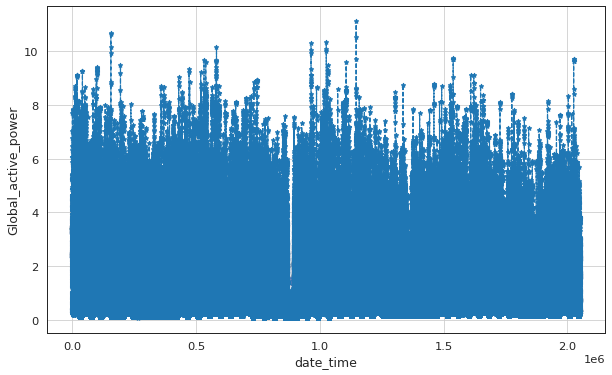

In [12]:
plt.figure(figsize=( 10 , 6 ))
plt.plot(df.index, df.Global_active_power, '--' , marker= '*' , )
plt.grid()
plt.xlabel( 'date_time' )
plt.ylabel( 'Global_active_power' )

In [13]:
#df_MA = df()
#MA = df_MA[ 'Global_active_power' ].rolling( 12 ).mean()

**Augmented Dickey-Fuller test for Stationarity**

In [14]:
# If p <= alpha: reject H0, not normal, If p > alpha: fail to reject H0, normal

stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


**Decompose into different components**

0         nan
1         nan
2         nan
3         nan
4         nan
           ..
2049275   nan
2049276   nan
2049277   nan
2049278   nan
2049279   nan
Name: Global_active_power, Length: 2049280, dtype: float64
0         -0.1324
1         -0.1712
2         -0.1808
3         -0.2124
4         -0.2087
            ...  
2049275    0.1328
2049276    0.1384
2049277    0.1924
2049278    0.1777
2049279    0.1974
Name: Global_active_power, Length: 2049280, dtype: float64
0         nan
1         nan
2         nan
3         nan
4         nan
           ..
2049275   nan
2049276   nan
2049277   nan
2049278   nan
2049279   nan
Name: Global_active_power, Length: 2049280, dtype: float64
0         4.2160
1         5.3600
2         5.3740
3         5.3880
4         3.6660
           ...  
2049275   0.6900
2049276   0.6880
2049277   0.6880
2049278   0.6880
2049279   0.6880
Name: Global_active_power, Length: 2049280, dtype: float64


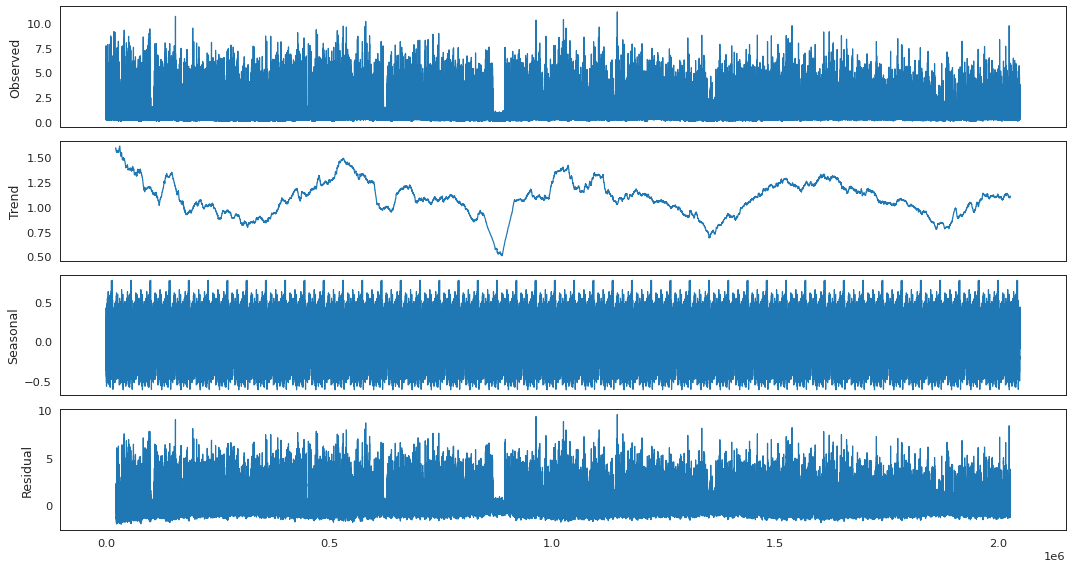

In [15]:
import statsmodels.api as sm
from pylab import rcParams
rcParams[ 'figure.figsize' ] = 15 , 8
decompose_series = sm.tsa.seasonal_decompose(df[ 'Global_active_power' ], model= 'additive', freq=(60*24*30) )

print(decompose_series.trend)
print(decompose_series.seasonal)
print(decompose_series.resid)
print(decompose_series.observed)
decompose_series.plot()
plt.show()

0         nan
1         nan
2         nan
3         nan
4         nan
           ..
2049275   nan
2049276   nan
2049277   nan
2049278   nan
2049279   nan
Name: Global_active_power, Length: 2049280, dtype: float64
0         0.9010
1         0.8570
2         0.8504
3         0.8204
4         0.8237
           ...  
2049275   1.0724
2049276   1.0778
2049277   1.1248
2049278   1.1182
2049279   1.1406
Name: Global_active_power, Length: 2049280, dtype: float64
0         nan
1         nan
2         nan
3         nan
4         nan
           ..
2049275   nan
2049276   nan
2049277   nan
2049278   nan
2049279   nan
Name: Global_active_power, Length: 2049280, dtype: float64
0         4.2160
1         5.3600
2         5.3740
3         5.3880
4         3.6660
           ...  
2049275   0.6900
2049276   0.6880
2049277   0.6880
2049278   0.6880
2049279   0.6880
Name: Global_active_power, Length: 2049280, dtype: float64


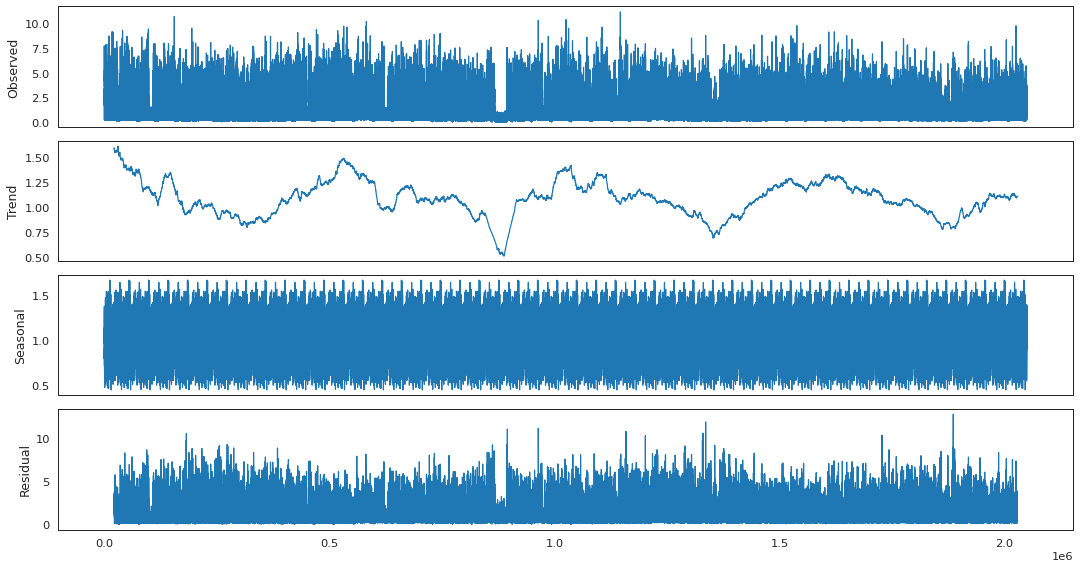

In [16]:
decompose_series = sm.tsa.seasonal_decompose(df[ 'Global_active_power' ], model= 'multiplicative', freq=(60*24*30) )

print(decompose_series.trend)
print(decompose_series.seasonal)
print(decompose_series.resid)
print(decompose_series.observed)
decompose_series.plot()
plt.show()

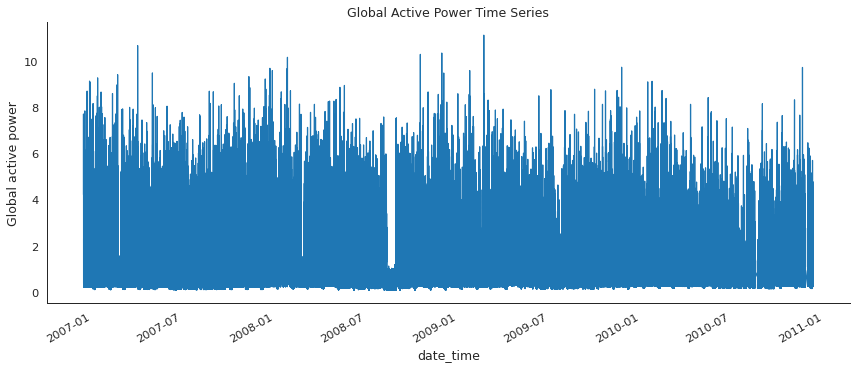

In [17]:
df1=df.loc[:,['date_time','Global_active_power']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

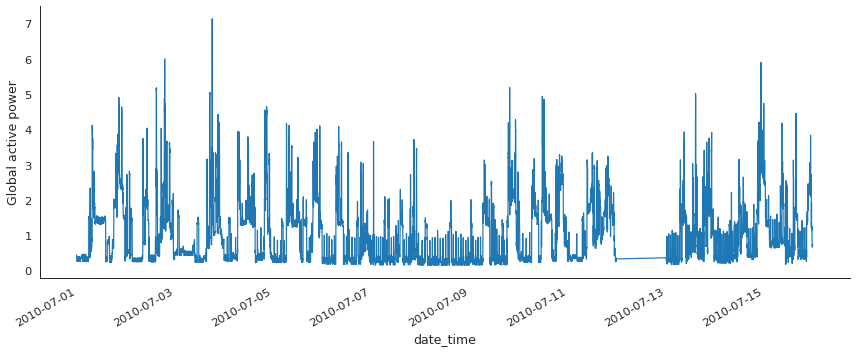

In [18]:
df2=df1[(df1.index>='2010-07-01') & (df1.index<'2010-7-16')]
df2.plot(figsize=(12,5));
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top=True)
plt.show();

**Box Plot of Yearly vs. Quarterly Global Active Power**

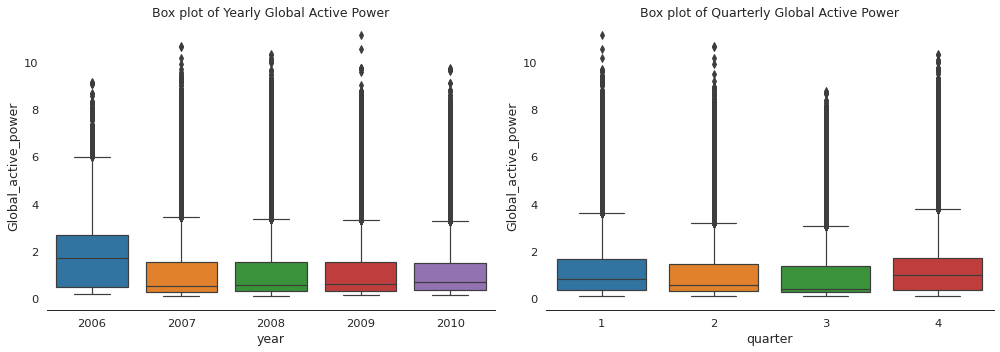

In [19]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()
plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

**Global Active Power Distribution**

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0000,1.0916,1.0573,0.0760,0.3080,0.6020,1.5280,11.1220


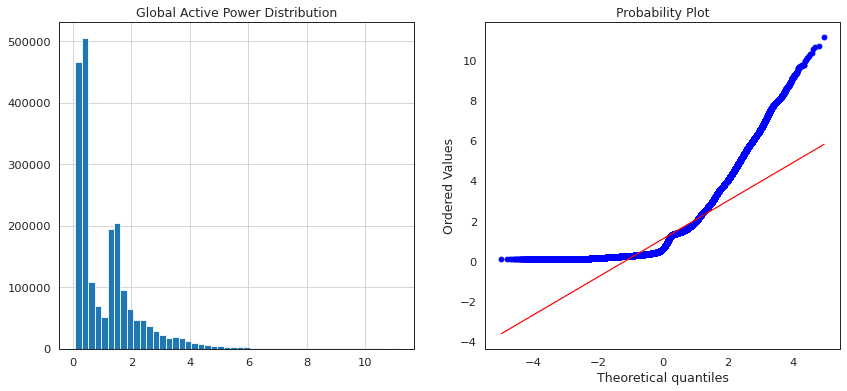

In [20]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')
plt.subplot(1,2,2)
stats.probplot(df['Global_active_power'], plot=plt);
df1.describe().T

**Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year**

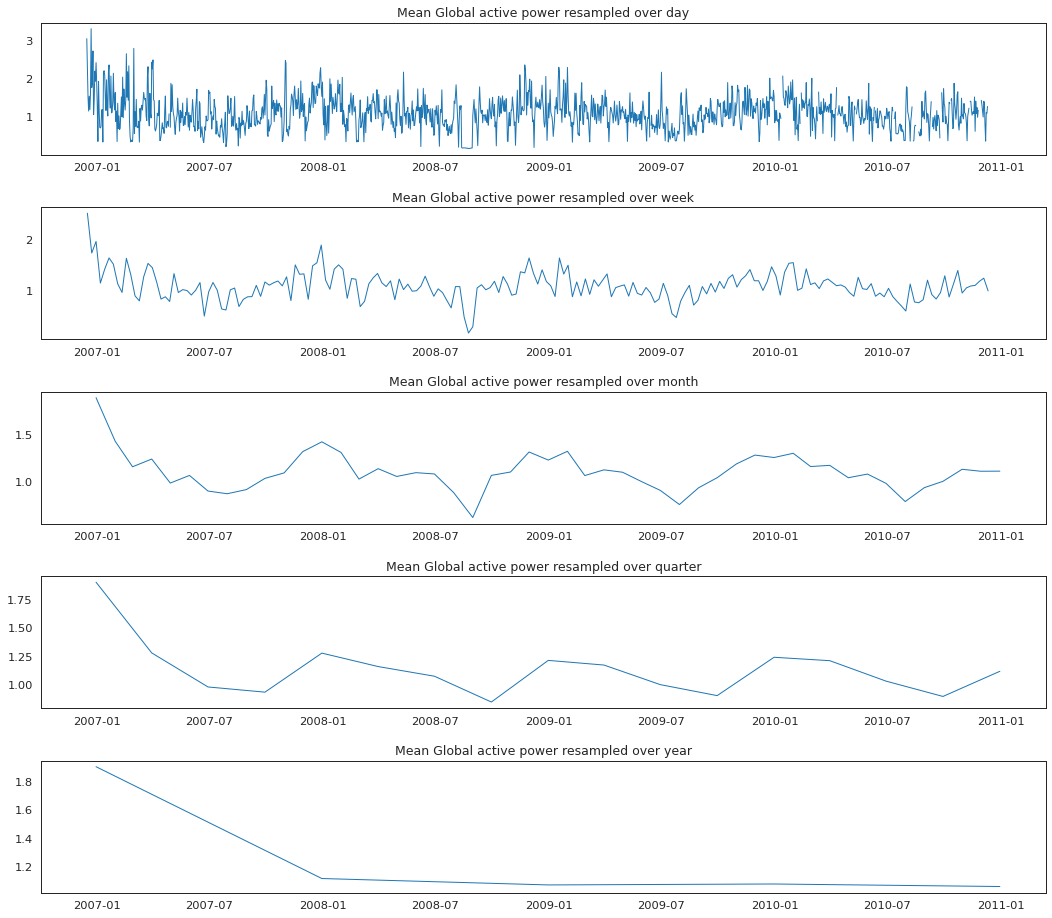

In [21]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

**Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day**

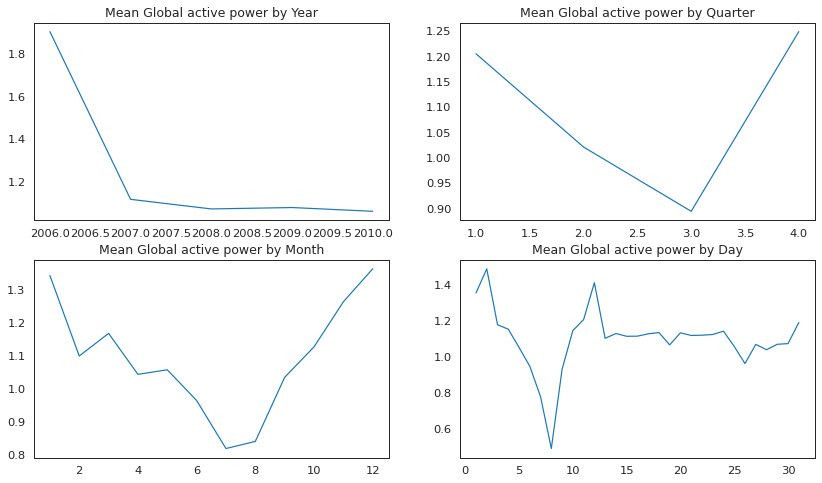

In [22]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
df.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
df.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
df.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
df.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

**Global Active Power by Years**
This time, we remove 2006.

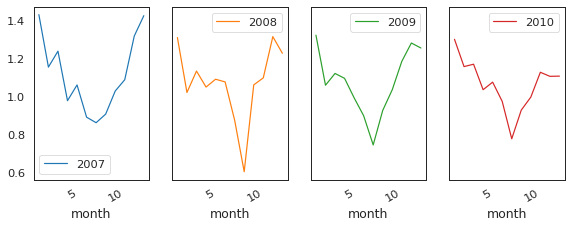

In [23]:
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

**Global Active Power Consumption in Weekdays vs. Weekends**

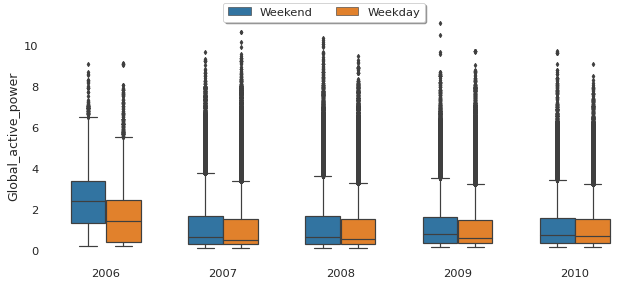

In [24]:
dic={0:'Weekend',1:'Weekday'}
df['Day'] = df.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=df)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

**Factor Plot of Global Active Power by Weekday vs. Weekend**

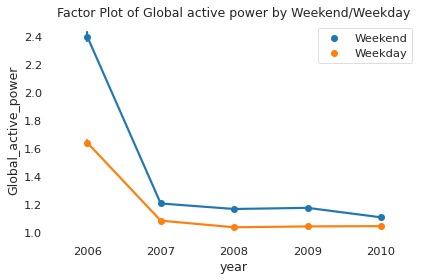

In [25]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=df, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

In [26]:
df2 = df1.resample('D').agg(np.mean)
#df2 - df1.resample('D').mean()

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


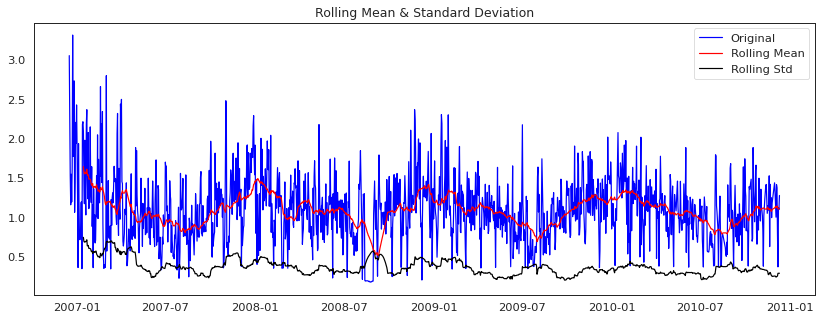

<Results of Dickey-Fuller Test>
Test Statistic                  -8.3277
p-value                          0.0000
#Lags Used                       9.0000
Number of Observations Used   1423.0000
Critical Value (1%)             -3.4350
Critical Value (5%)             -2.8636
Critical Value (10%)            -2.5679
dtype: float64


In [27]:
test_stationarity(df2.Global_active_power.dropna())

**ACF and PACF plots**

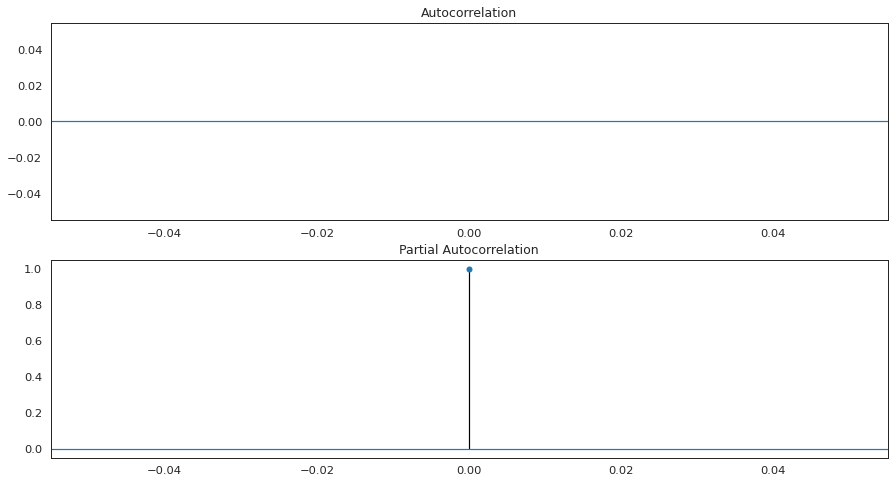

In [29]:
# plots
plt.figure()
lags = 365
# acf
axis = plt.subplot(2, 1, 1)
plot_acf(df2, ax=axis, lags=lags)
# pacf
axis = plt.subplot(2, 1, 2)
plot_pacf(df2, ax=axis, lags=lags)
# show plot
plt.show()

In [ ]:
df2.shape

**Prepare the dataset for modeling**

In [30]:
#We can reduce the computation time, and also get a quick result to test the model by resampling the data over maybe hourly. 
#I will keep it in minute as required.

#Create the dataset, ensure all data is float
dataset = df.Global_active_power.values #numpy.ndarray
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1))

#Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

#Split into training and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

#Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)
    
look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [31]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1639393, 1, 30)
(1639393,)
(409825, 1, 30)
(409825,)


**Using ARIMA model**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               ARMA Model Results                              
Dep. Variable:     Global_active_power   No. Observations:              2049280
Model:                      ARMA(7, 0)   Log Likelihood             -167646.425
Method:                        css-mle   S.D. of innovations              0.263
Date:                 Tue, 13 Oct 2020   AIC                         335310.849
Time:                         22:58:41   BIC                         335423.646
Sample:                              0   HQIC                        335341.025
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.0917      0.007    159.437      0.000       1.078       1.105
ar.L1.Global_active_power     1.0105      0.001   1447.520      0.000       1.

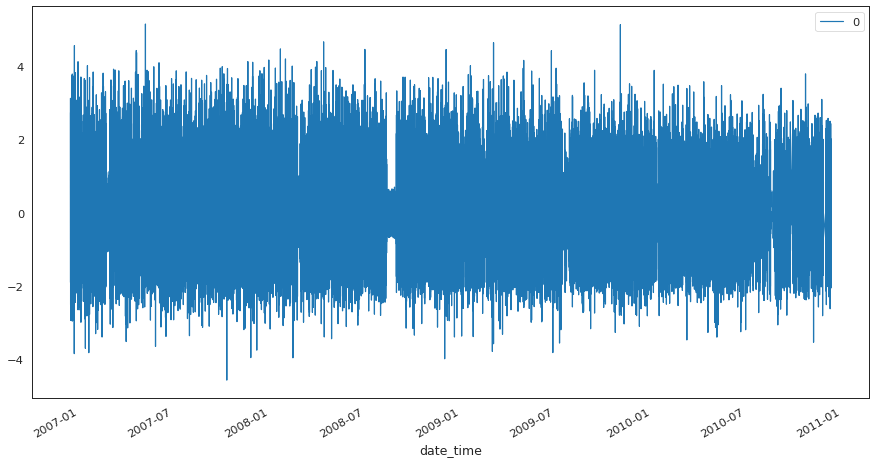

In [ ]:
from pandas import DataFrame
# fit model
model = ARIMA(df1, order=(7,0,0))
model_fit = model.fit(disp=False)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

**Using LSTM Model Architecture**

In [ ]:
#The task here will be to predict values for a time series given the history of 2 million minutes of a household’s power consumption. 
#I will be using a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, Y_train, epochs=20, batch_size=70, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

model.summary()

**Make Predictions**

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

In [ ]:
#Plot Model Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
#comparing the actual and predictions for the last 200 minutes
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();